In [120]:
import matplotlib.pyplot as plt
from random import randint

from torch_geometric.datasets import ExplainerDataset, BA2MotifDataset
from torch_geometric.datasets.graph_generator import BAGraph
from torch_geometric.explain import Explainer, GNNExplainer, PGExplainer, DummyExplainer

import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx

import torch
import torch.nn.functional as F

import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, Linear, global_add_pool, GraphConv
from torch_geometric.explain.metric import fidelity, unfaithfulness

from torch_geometric.utils import scatter

torch_geometric.seed_everything(41)

In [202]:
dataset = BA2MotifDataset('../data').shuffle()
    
train_dataset = dataset[:int(len(dataset) * 0.8)]
test_dataset = dataset[int(len(dataset) * 0.2):]
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)
train_loader = DataLoader(train_dataset, batch_size=64)

tensor([0])


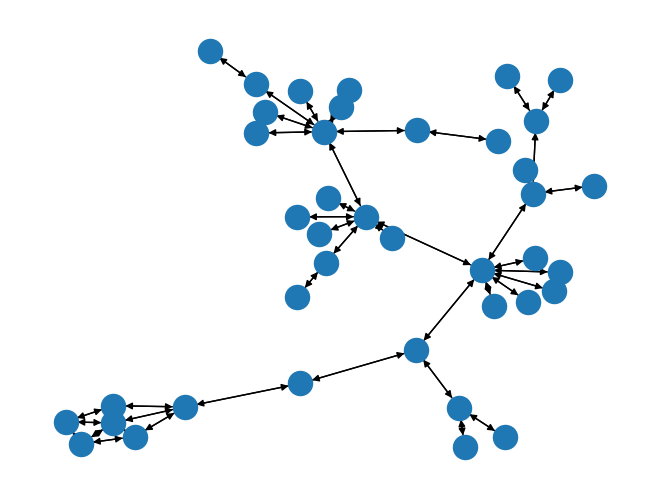

In [203]:
net = to_networkx(dataset[0])
print(dataset[0].y)
nx.draw(net)

In [204]:
class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()

        num_features = dataset.num_features
        self.dim = dim

        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        x = self.conv4(x, edge_index).relu()
        x = self.conv5(x, edge_index).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.sigmoid(x)

In [205]:
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        data.y = torch.tensor(list(map(lambda y: [0,1] if y == 1 else [1,0], data.y))).float()        
        loss = F.binary_cross_entropy(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        output = model(data.x, data.edge_index, data.batch)
        pred = torch.tensor(list(map(lambda p: [0,1] if p[1] > p[0] else [1,0], output))).float()
        y = torch.tensor(list(map(lambda y: [0,1] if y == 1 else [1,0], data.y))).float()
        correct += pred.eq(y).sum().item()/2
    return correct / len(loader.dataset)

In [206]:
model = Net(dim=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 70):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Loss: 0.8417, Train Acc: 0.6288, Test Acc: 0.6400
Epoch: 002, Loss: 0.6596, Train Acc: 0.6350, Test Acc: 0.6475
Epoch: 003, Loss: 0.6475, Train Acc: 0.6713, Test Acc: 0.6825
Epoch: 004, Loss: 0.6082, Train Acc: 0.7338, Test Acc: 0.7488
Epoch: 005, Loss: 0.5547, Train Acc: 0.8050, Test Acc: 0.8100
Epoch: 006, Loss: 0.5037, Train Acc: 0.8500, Test Acc: 0.8625
Epoch: 007, Loss: 0.4398, Train Acc: 0.8825, Test Acc: 0.8800
Epoch: 008, Loss: 0.3955, Train Acc: 0.8750, Test Acc: 0.8638
Epoch: 009, Loss: 0.3522, Train Acc: 0.9087, Test Acc: 0.9025
Epoch: 010, Loss: 0.3353, Train Acc: 0.9050, Test Acc: 0.9025
Epoch: 011, Loss: 0.3182, Train Acc: 0.9250, Test Acc: 0.9250
Epoch: 012, Loss: 0.3011, Train Acc: 0.9287, Test Acc: 0.9250
Epoch: 013, Loss: 0.2874, Train Acc: 0.9475, Test Acc: 0.9437
Epoch: 014, Loss: 0.2770, Train Acc: 0.9437, Test Acc: 0.9463
Epoch: 015, Loss: 0.2664, Train Acc: 0.9425, Test Acc: 0.9475
Epoch: 016, Loss: 0.2556, Train Acc: 0.9475, Test Acc: 0.9475
Epoch: 0

In [207]:
print(model(dataset[10].x, dataset[10].edge_index, batch = torch.zeros(len(dataset[10].x), dtype=int)))
dataset[10].y

tensor([[1.0000e+00, 1.0158e-29]], grad_fn=<SigmoidBackward0>)


tensor([0])

In [252]:
gnnexplainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=300),
    explanation_type='phenomenon',
    node_mask_type=None,
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='probs',
    ),
    threshold_config=dict(
        threshold_type='topk',
        value=7
    )
)


pgexplainer = Explainer(
    model=model,
    algorithm=PGExplainer(epochs=200),
    explanation_type='phenomenon',
    node_mask_type=None,
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='probs',
    )
)


dummyexplainer = Explainer(
    model=model,
    algorithm=DummyExplainer(),
    explanation_type='phenomenon',
    node_mask_type=None,
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='probs',
    ),
    threshold_config=dict(
        threshold_type='topk',
        value=7
    )
)

In [217]:
gnnexplainer_Unfaithfulness = []
dummyepxplainer_Unfaithfulness = []
for graph in dataset: 
    
    batch = torch.zeros(len(graph.x), dtype = int)
    if graph.y == 1:
        target = torch.tensor([0,1])
    else:
        target = torch.tensor([1,0])
        
    gnnexplanation = gnnexplainer(graph.x, graph.edge_index, target=target, batch=batch) 
    gnn_unf = unfaithfulness(gnnexplainer, gnnexplanation)
    
    dummyexplanation = dummyexplainer(graph.x, graph.edge_index, target=target, batch=batch)
    dummy_unf = unfaithfulness(dummyexplainer, dummyexplanation)
    
    gnnexplainer_Unfaithfulness.append(gnn_unf)
    dummyepxplainer_Unfaithfulness.append(dummy_unf)
    
    print(f"GNNExplainer unfaithfulness: {gnn_unf}")
    print(f"DummyExplainer unfaithfulness: {dummy_unf} \n\n")

GNNExplainer unfaithfulness: 0.0
DummyExplainer unfaithfulness: 0.0 


GNNExplainer unfaithfulness: 0.9975946107879281
DummyExplainer unfaithfulness: 0.9975946107879281 


GNNExplainer unfaithfulness: 0.0
DummyExplainer unfaithfulness: 0.0 


GNNExplainer unfaithfulness: 0.9890693742781878
DummyExplainer unfaithfulness: 0.9890693742781878 


GNNExplainer unfaithfulness: 0.9820304363965988
DummyExplainer unfaithfulness: 0.9820304363965988 


GNNExplainer unfaithfulness: 0.9978763242252171
DummyExplainer unfaithfulness: 0.9978763242252171 


GNNExplainer unfaithfulness: 0.0
DummyExplainer unfaithfulness: 0.0 


GNNExplainer unfaithfulness: 0.9822787772864103
DummyExplainer unfaithfulness: 0.9822787772864103 


GNNExplainer unfaithfulness: 1.1920928955078125e-07
DummyExplainer unfaithfulness: 1.1920928955078125e-07 




KeyboardInterrupt: 

Actual label: tensor([0, 1]) vs Predicted label: tensor([[0.0024, 0.9964]], grad_fn=<SigmoidBackward0>)


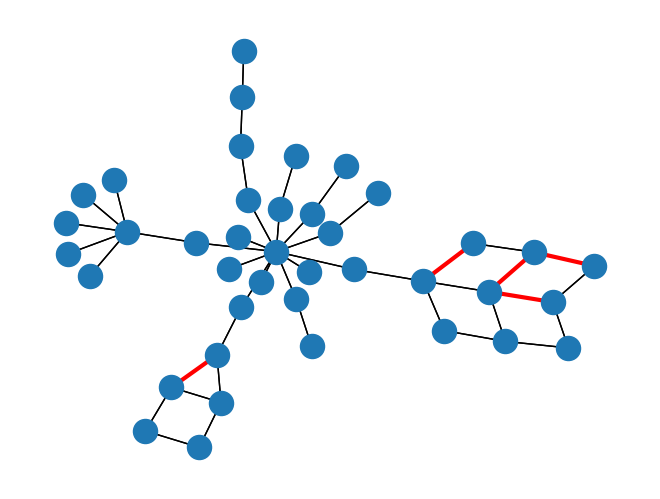

In [255]:
def visualize_gnnexplainer_explanation(graph):
    if graph.y == 1:
        target = torch.tensor([0,1])
    else:
        target = torch.tensor([1,0])
    
    prediction = model(graph.x, graph.edge_index, batch = torch.zeros(len(graph.x), dtype=int))
    
    print(f"Actual label: {target} vs Predicted label: {prediction}")

    explanation = gnnexplainer(graph.x, graph.edge_index, target = target , batch = torch.zeros(len(dataset[10].x), dtype=int))
    graph = to_networkx(graph)
    graph = graph.copy().to_undirected()

    pos = nx.kamada_kawai_layout(graph)


    widths = [3 if x > 0 else 1 for x in explanation.edge_mask]
    edge_color = [(1,0,0) if x > 0 else (0,0,0) for x in explanation.edge_mask]
    nx.draw(graph, pos=pos)
    nx.draw_networkx_edges(graph, pos=pos, width=widths, edge_color=edge_color)

graph = dataset[1]
visualize_gnnexplainer_explanation(graph)